In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rail import CPI

cpi = CPI()

In [33]:
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import lognorm
from collections import OrderedDict, UserString, UserDict
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', -1)
plt.style.use('seaborn-poster')


class Tree(UserDict):
    def __init__(self, name: str, parent=None, sort: bool=True) -> None:
        self.data = {}
        self.name = name
        self.parent = parent
        self.sort = sort

    def addChild(self, name: str) -> 'Tree':
        self.data[name] = Tree(name=name, parent=self, sort=self.sort)
        if self.sort:
            self.data = OrderedDict(sorted(self.data.items(), key=lambda x: x[1].name))
        return self.data[name]

    def path(self) -> str:
        if self.parent:
            return self.parent.path() + '/' + self.name
        else:
            return '/' + self.name

    def to_print(self) -> None:
        print(self.path())
        for child in self.data.values():
            child.to_print()

    def to_latex(self) -> None:
        print('child { node{' + self.name + '}')
        for child in self.data.values():
            child.to_latex()
        print('}')

    def to_dict_list(self) -> dict:
        outdict = {}
        outdict['name'] = self.name
        outdict['children'] = []
        for child in self.data.values():
            outdict['children'].append(child.to_dict_list())
        return outdict


class ThreatSource(UserDict):
    def __init__(self, name: str) -> None:
        self.data = {}
        self.data['name'] = name


class ThreatSources(UserDict):
    def new(self, name: str) -> ThreatSource:
        self.data[name] = ThreatSource(name)
        return self.data[name]


class ThreatEvent(UserDict):
    def __init__(self, name: str, threat_source: ThreatSource) -> None:
        self.data = {}
        self.data['name'] = name
        self.data['threat_source'] = threat_source


class ThreatEvents(UserDict):
    def new(self, name: str, threat_source: ThreatSource) -> ThreatEvent:
        self.data[name] = ThreatEvent(name, threat_source)
        return self.data[name]


class Control(UserDict):
    def __init__(self, name: str, cost: float, reduction: float, implemented: bool=True) -> None:
        self.data = {}
        self.data['name'] = name
        self.data['cost'] = cost
        self.data['reduction'] = reduction
        self.data['implemented'] = implemented

    def evaluate_lognormal(self, iterations=1):
        return Control(
            name = self.data['name'],
            cost = lognorm.ppf(np.random.rand(iterations), s=np.log(self.data['cost'])),
            reduction = lognorm.ppf(np.random.rand(iterations), s=np.log(self.data['reduction'])),
            implemented = self.data['implemented']
        )


class Controls(UserDict):
    def __init__(self) -> None:
        self.data = {}

    def new(self, name: str, cost: float, reduction: float) -> Control:
        self.data[name] = Control(name, cost, reduction)
        return self.data[name]

    def costs(self):
        return np.sum(list(map(lambda x: x['cost'] if x['implemented'] is True else 0, self.data.values())))

    def costs_lognormal(self):
        return np.sum(list(map(lambda x: x.evaluate_lognormal().data['cost'] if x.data['implemented'] is True else 0, self)))



class Vulnerability(UserDict):
    def __init__(self, threat_event: ThreatEvent, system: Tree, controls: [Control] = []) -> None:
        self.data = {}
        self.data['name'] = threat_event['name'] + ' -> ' + system.path() + ' | ' + str(controls)
        self.data['threat_event'] = threat_event
        self.data['system'] = system
        self.data['controls'] = controls


class Vulnerabilities(UserDict):
    def new(self, threat_event: ThreatEvent, system: Tree, controls: [Control] = []) -> Vulnerability:
        name = threat_event['name'] + ' -> ' + system.path() + ' | ' + str(controls)
        self.data[name] = Vulnerability(threat_event, system, controls)
        return self.data[name]


class Likelihood(UserDict):
    def __init__(self, lam: float) -> None:
        if lam < 0:
            raise ValueError('Likelihood value lam must be greater than or equal to zero.')
        self.data = {}
        self.data['name'] = str(lam)
        self.data['lam'] = lam

    def plot(self, axes=None) -> tuple:
        s = np.random.poisson(self.data['lam'], 10000)
        plt.title('%s (histogram)' % (self.data['name']))
        plt.ylabel('relative frequency')
        plt.xlabel('likelihood')
        return plt.hist(s, 14, normed=True, axes=axes)


class Impact(UserDict):
    def __init__(self, name: str, mu: float, sigma: float) -> None:
        if mu < 0:
            raise ValueError('Impact value mu must be greater than or equal to 0.')
        if sigma < 0:
            raise ValueError('Impact value s must be greater than or equal to 0.')
        self.data = {}
        self.data['name'] = name
        self.data['mean'] = np.exp(mu + sigma**2 / 2)
        self.data['median'] = np.exp(mu)
        self.data['mu'] = mu
        self.data['sigma'] = sigma

    def from_lower_90_upper_90(name: str, lower_90: float, upper_90: float):
        if lower_90 < 0:
            raise ValueError('Impact value lower_90 must be greater than or equal to 0.')
        if upper_90 < 0:
            raise ValueError('Impact value upper_90 must be greater than or equal to 0.')
        if lower_90 >= upper_90:
            raise ValueError('Impact value upper_90 must be greater than value lower_90.')
        sigma = (np.log(upper_90) - np.log(lower_90)) / 3.29
        mu = (np.log(lower_90) + np.log(upper_90)) / 2
        return Impact(name, mu, sigma)

    def plot(self, num=1000, axes=None) -> list:
        x = np.linspace(
            lognorm.ppf(0.001, s=self.data['sigma'], scale=np.exp(self.data['mu'])),
            lognorm.ppf(0.999, s=self.data['sigma'], scale=np.exp(self.data['mu'])),
            num
        )
        plt.title('%s (PDF)' % (self.data['name']))
        plt.ylabel('relative likelihood')
        plt.xlabel('impact')
        return plt.plot(x, lognorm.pdf(x, s=self.data['sigma'], scale=np.exp(self.data['mu'])), axes=axes)


class Risk(UserDict):
    def __init__(self, vulnerability: Vulnerability, likelihood: Likelihood, impact: Impact) -> None:
        self.data = {}
        self.data['name'] = vulnerability['name'] + ' -> ' + likelihood['name'] + ' -> ' + impact['name']
        self.data['vulnerability'] = vulnerability
        self.data['likelihood'] = likelihood
        self.data['impact'] = impact

    def evaluate_deterministic(self) -> float:
        reduction = np.product(list(map(lambda x: x['reduction'] if x['implemented'] is True else 1, self.data['vulnerability']['controls'])))
        return self.data['likelihood']['lam'] * self.data['impact']['mean'] * reduction

    def evaluate_lognormal(self, iterations: int = 1000) -> float:
        reduction = np.product(list(map(lambda x: x['reduction'] if x['implemented'] is True else 1, self.data['vulnerability']['controls'])))
        return lognorm.ppf(np.random.rand(iterations), s=self.data['impact']['sigma'], scale=np.exp(self.data['impact']['mu'])) * np.random.poisson(lam=self.data['likelihood']['lam'] * reduction, size=iterations)


class Risks(UserDict):
    def __init__(self) -> None:
        self.data = {}
        self.dataframe = pd.DataFrame(columns=['Threat Source', 'Threat Event', 'System', 'Controls', 'Impact', 'Impact (mean)', 'Likelihood (mean)'])
        self.cost_loss = []

    def new(self, vulnerability: Vulnerability, likelihood: Likelihood, impact: Impact) -> Risk:
        name = vulnerability['name'] + ' -> ' + likelihood['name'] + ' -> ' + impact['name']
        self.data[name] = Risk(vulnerability, likelihood, impact)
        self.dataframe = self.dataframe.append({
            'Threat Source': vulnerability['threat_event']['threat_source']['name'],
            'Threat Event': vulnerability['threat_event']['name'],
            'System': vulnerability['system'].path(),
            'Controls': list(map(lambda x: x['name'], vulnerability['controls'])),
            'Impact': impact['name'],
            'Impact (mean)': impact['mean'],
            'Likelihood (mean)': likelihood['lam'],
        }, ignore_index=True)
        return self.data[name]

    def calculate_stochastic_risks(self, interations: int = 100000):
        risks_scores = np.array(list(map(lambda row: row.evaluate_lognormal(interations), self.data.values())))
        return risks_scores.sum(axis=0)

    def plot(self, axes=None):
        plt.title('expected loss')
        plt.xlabel('loss')
        plt.ylabel('probability')
        return plt.hist(self.calculate_stochastic_risks(), histtype='step', bins=10000, cumulative=-1, normed=True, axes=axes)

    def expected_loss_stochastic_mean(self, interations: int = 1000) -> float:
        return self.calculate_stochastic_risks(interations).sum() / interations

    def expected_loss_deterministic_mean(self) -> float:
        return np.array(list(map(lambda row: row.evaluate_deterministic(), self.data.values()))).sum()

    def calculate_dataframe_deterministic_mean(self):
        df = risks.dataframe.copy()
        df['Risk (mean)'] = list(map(lambda x: x.evaluate_deterministic(), self.data.values()))
        return df

    def determine_optimum_controls(self, controls, controls_to_optimize, stochastic=False):
        if not controls_to_optimize:
            loss = self.expected_loss_deterministic_mean()
            if stochastic:
                cost = controls.costs_lognormal()
            else:
                cost = controls.costs()
            self.cost_loss.append({'cost': cost, 'loss': loss})
            return {'loss': loss, 'cost': cost, 'controls': copy.deepcopy(controls)}
        else:
            controls_to_optimize_new_list = list(controls_to_optimize)
            control = controls_to_optimize_new_list.pop()
            controls[control]['implemented'] = False
            control_off = self.determine_optimum_controls(controls, controls_to_optimize_new_list)
            controls[control]['implemented'] = True
            control_on = self.determine_optimum_controls(controls, controls_to_optimize_new_list)
            if control_on['loss'] + control_on['cost'] < control_off['loss'] + control_off['cost']:
                optimal_control = control_on
            else:
                optimal_control = control_off
            return optimal_control

    def set_optimum_controls(self, controls):
        optimum_controls = self.determine_optimum_controls(controls, controls)
        for control in optimum_controls['controls']:
            if optimum_controls['controls'][control]['implemented'] is True:
                controls[control]['implemented'] = True
            else:
                controls[control]['implemented'] = False
        df = pd.DataFrame(list(optimum_controls['controls'].values())).set_index('name')
        return df

    def plot_risk_cost_matrix(self, controls, axes=None):
        self.set_optimum_controls(controls)
        df = pd.DataFrame(self.cost_loss)
        plt.title('residual risk versus control cost')
        plt.ylabel('residual risk')
        plt.xlabel('control cost')
        plt.scatter(df['cost'], df['loss'], axes=axes)
        plt.scatter(controls.costs(), risks.expected_loss_deterministic_mean(), color='red', axes=axes)
        axes.set_xlim(xmin=0)

    def sensitivity_test(self, controls, iterations=1000):
        results = []
        for i in range(iterations):
            results.append(self.determine_optimum_controls(controls, controls, stochastic=True)['controls'].values())
        return results

### 1. Model the autonomous vehicle system. Here we model the system as a tree with different subsystems.

In [34]:
AutonomousVehicleSystem = Tree(name='Autonomous Vehicle System')
AutonomousVehicleSystem.addChild('Autonomous Vehicle')
AutonomousVehicleSystem['Autonomous Vehicle'].addChild('Actuator')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator'].addChild('Lateral Control')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator'].addChild('Longitudinal Control')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Longitudinal Control'].addChild('Braking (Deceleration)')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Longitudinal Control'].addChild('Powertrain (Acceleration)')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator'].addChild('Other Actuator')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Other Actuator'].addChild('Climate Control')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Other Actuator'].addChild('Dashboard/displays')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Other Actuator'].addChild('Door locks/windows')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Other Actuator'].addChild('Horn')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Other Actuator'].addChild('Lights/signals')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Other Actuator'].addChild('Radio')
AutonomousVehicleSystem['Autonomous Vehicle']['Actuator']['Other Actuator'].addChild('Windshield wipers/fluid')
AutonomousVehicleSystem['Autonomous Vehicle'].addChild('Cables')
AutonomousVehicleSystem['Autonomous Vehicle'].addChild('Computers')
AutonomousVehicleSystem['Autonomous Vehicle'].addChild('Local Area Networks')
AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'].addChild('Bluetooth')
AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'].addChild('Cellular')
AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'].addChild('Controller Area Network (CAN) Bus')
AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'].addChild('Ethernet')
AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'].addChild('Near field communications')
AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'].addChild('Tire-pressure monitoring system')
AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'].addChild('WiFi')
AutonomousVehicleSystem['Autonomous Vehicle'].addChild('Power Supply')
AutonomousVehicleSystem['Autonomous Vehicle'].addChild('Sensors')
AutonomousVehicleSystem['Autonomous Vehicle']['Sensors'].addChild('Cameras')
AutonomousVehicleSystem['Autonomous Vehicle']['Sensors'].addChild('Global navigation satellite system')
AutonomousVehicleSystem['Autonomous Vehicle']['Sensors'].addChild('Lidar')
AutonomousVehicleSystem['Autonomous Vehicle']['Sensors'].addChild('Radar')
AutonomousVehicleSystem['Autonomous Vehicle']['Sensors'].addChild('CAN Bus sensors')
AutonomousVehicleSystem['Autonomous Vehicle']['Sensors'].addChild('Ultrasonic')
AutonomousVehicleSystem['Autonomous Vehicle'].addChild('WAN networking equipment')
AutonomousVehicleSystem.addChild('Teleoperation Facilities')
AutonomousVehicleSystem['Teleoperation Facilities'].addChild('Cables')
AutonomousVehicleSystem['Teleoperation Facilities'].addChild('Computer')
AutonomousVehicleSystem['Teleoperation Facilities']['Computer'].addChild('Controls')
AutonomousVehicleSystem['Teleoperation Facilities']['Computer'].addChild('Monitor')
AutonomousVehicleSystem['Teleoperation Facilities'].addChild('WAN networking equipment')
AutonomousVehicleSystem.addChild('Wide Area Networks')
AutonomousVehicleSystem['Wide Area Networks'].addChild('Cellular network')
AutonomousVehicleSystem['Wide Area Networks'].addChild('Internet')
AutonomousVehicleSystem.addChild('Process')
AutonomousVehicleSystem.addChild('People')

{}

### 2. Model our threat sources.

In [35]:
threat_sources = ThreatSources()
threat_sources.new('Adversarial')
threat_sources.new('Non-adversarial')

{'name': 'Non-adversarial'}

### 3. Model the possible impacts.

Intentional crash means something similar to the truck attacks in Nice or Berlin.

Accidental crash means the autonomous system fails to control the vehicle and it crashes into whatever is around.

Disabled vehicle means the autonomous system is broken in some way that requires repair.

Disabled vehicle fleet means all vehicles in the fleet are broken in some way that require repair.


In [36]:
TotalCosts = 835793000000
TotalCrashes = 13565773
AverageCostPerCrash = TotalCosts / TotalCrashes
AverageCostPerCrash

average_cost = cpi.inflation(2010, 2018) * AverageCostPerCrash  # blincoe_economic_2015
truck_bus_cost = cpi.inflation(2000, 2018) * 59153  # zaloshnja_costs_2004

fleet_size = 10

IntentionalCrash = Impact.from_lower_90_upper_90('Malicious Crash', 10000000, 100000000)
AccidentialCrash = Impact('Uncontrolled Crash', np.log(average_cost), 1)
DisabledVehicle = Impact('Disabled Vehicle', np.log(10000), 1)
print(average_cost, truck_bus_cost)

70830.38977965387 86613.08323770492


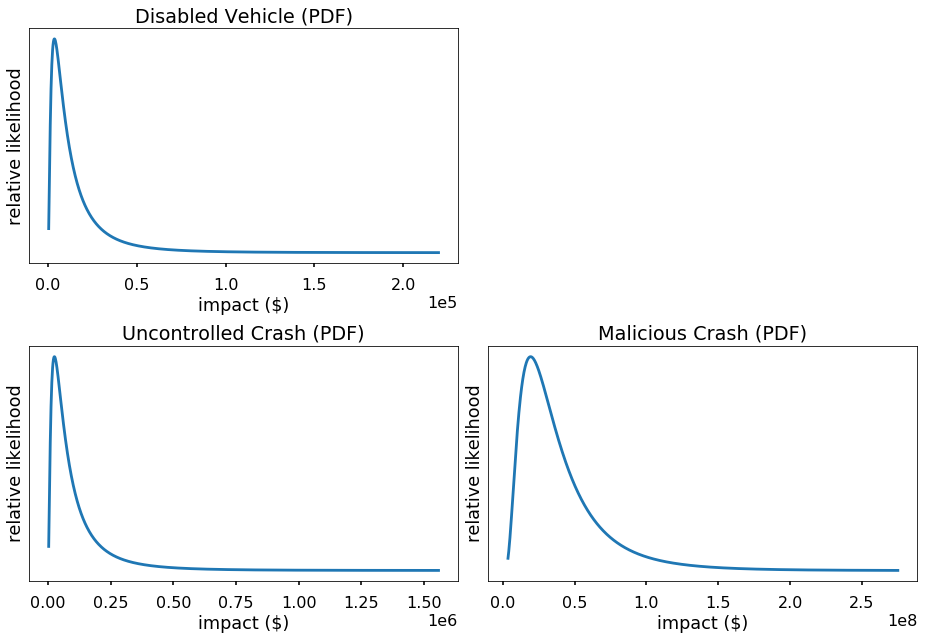

In [37]:
fig = plt.figure()

ax1 = fig.add_subplot(2, 2, 1)
DisabledVehicle.plot(axes=ax1)
ax1.get_yaxis().set_ticks([])
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax1.set_xlabel('impact ($)')

ax3 = fig.add_subplot(2, 2, 3)
AccidentialCrash.plot(axes=ax3)
ax3.get_yaxis().set_ticks([])
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax3.set_xlabel('impact ($)')

ax4 = fig.add_subplot(2, 2, 4)
IntentionalCrash.plot(axes=ax4)
ax4.get_yaxis().set_ticks([])
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax4.set_xlabel('impact ($)')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### 4. Model our controls.

In [38]:
controls = Controls()
'''
controls.new('Safety driver', 100000 * fleet_size, .01)
controls.new('Network segmentation', 100000, .1)
controls.new('Unique user accounts', 10000, .1)
controls.new('Audit log monitoring', 10000, .1)
controls.new('Configuration management', 10000, .1)
controls.new('Backups', 10000, .1)
controls.new('Redundant power', 10000, .1)
controls.new('Fire supression system', 10000 * fleet_size, .1)
controls.new('Egress controls / HTTP proxy', 10000, .1)
controls.new('Firewall', 10000, .1)
controls.new('Security awareness/training', 10000, .1)
controls.new('Incident response program', 10000, .1)
controls.new('Penetration test', 10000, .1)
controls.new('Automated account management', 10000, .1)
controls.new('User security policy', 500, .9)
controls.new('AWS audit', 10000, .1)
controls.new('Reduce attack surface', 10000, 0)
controls.new('Code signing', 10000, .1)
controls.new('Data signing', 10000, .1)
controls.new('Secure boot', 10000, .1)
controls.new('Hardware security module', 10000, .1)
controls.new('Secret storage', 10000, .1)
controls.new('Intrusion detection system', 10000, .1)
controls.new('Full-disk encrytpion', 10000, .1)
controls.new('Network access control', 10000, .1)
controls.new('Logging/monitoring', 10000, .1)
controls.new(Employee education', 10000, .5)
controls.new(Hardware inventory', 10000, .5)
controls.new(Library inventory', 10000, .5)
controls.new(Application inventory', 10000, .5)
controls.new('Transport-layer security (Secure ROS)', 10000, .1)
'''

controls.new('Vulnerability management program', 100000, .01)  # patching once every 2 years -> once every week
controls.new('Anti-malware software', 10000, .1)  # assume software blocks 90% of malware
controls.new('Two-factor authentication', 50000, .1)
controls.new('Disable WiFi', 1000, 0)
controls.new('Physical security at teleoperation facilities', 10000, .1)
controls.new('Physical security of vehicles', 10000 * fleet_size, .1)
controls.new('Redundant teleoperation facility', 100000, .01)
controls.new('Autonomous system protections for remote operations', 500000, .01)
controls.new('Background checks for drivers', 10000, .01)

{'name': 'Background checks for drivers', 'cost': 10000, 'reduction': 0.01, 'implemented': True}

### 5. Create all the possible risks. Risks are a vulnerability, likelihood, and impact. A vulnerability is a threat event, system, and controls. 

In [39]:
threat_events = ThreatEvents()
vulnerabilities = Vulnerabilities()
risks = Risks()
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains access to teleoperation computer via outdated software on teleoperation computer", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Teleoperation Facilities']['Computer'],
        [controls['Vulnerability management program'], controls['Autonomous system protections for remote operations']]),
    Likelihood(.1),  # assume 1 indicent every 10 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains physical access to teleoperation computer", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Teleoperation Facilities']['Computer'],
        [controls['Physical security at teleoperation facilities'], controls['Autonomous system protections for remote operations']]),
    Likelihood(.01),  # assume 1 incident every 100 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains remote access to vehicle network via vpn", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['WAN networking equipment'],
        [controls['Two-factor authentication'], controls['Autonomous system protections for remote operations']]),
    Likelihood(.1),  # assume 1 incident every 10 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains remote access to vehicle network by exploiting software bug on WAN networking equipment", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['WAN networking equipment'],
        [controls['Vulnerability management program'], controls['Autonomous system protections for remote operations']]),
    Likelihood(.01),  # assume 1 incident every 100 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains access to teleoperation network via vpn", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Teleoperation Facilities']['WAN networking equipment'],
        [controls['Two-factor authentication'], controls['Autonomous system protections for remote operations']]),
    Likelihood(.1),  # assume 1 incident every 10 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains access to vehicle via malware on teloperation computer", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Teleoperation Facilities']['Computer'],
        [controls['Anti-malware software'], controls['Autonomous system protections for remote operations']]),
    Likelihood(.01),  # assume 1 incident every 100 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains access to vehicle via malware on vehicle computer", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Computers'],
        [controls['Anti-malware software'], controls['Autonomous system protections for remote operations']]),  # assume 1 incident every 100 years
    Likelihood(.01),
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Fire in the vehicle", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']),
    Likelihood(.01 * fleet_size),  # assume 1 incident every 100 years per vehicle
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Fire in the teleoperation facility", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle'],
        [controls['Redundant teleoperation facility']]),
    Likelihood(.01),  # assume 1 incident every 100 years
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Hardware failure of a vehicle system", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']),
    Likelihood(.1),  # assume 1 incident every 10 years
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Hardware failure of a teleoperation system", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Teleoperation Facilities'],
        [controls['Redundant teleoperation facility']]),
    Likelihood(.1),  # assume 1 incident every 10 years
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Vehicle crash dislodges sensors", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Sensors']),
    Likelihood(.1 * fleet_size),  # assume 1 incident every 10 years per vehicle
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Bumps dislodge vehicle computers", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Computers']),
    Likelihood(.1 * fleet_size),  # assume 1 incident every 10 years per vehicle
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Rain/snow/fog disrupts sensors", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Sensors']),
    Likelihood(.1),  # assume 1 incident every 10 years
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Theft of a vehicle component", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle'],
        [controls['Physical security of vehicles']]),
    Likelihood(.1),  # assume 1 incident every 10 years
    DisabledVehicle)
risks.new(
    vulnerabilities.new(
        threat_events.new("Theft of a teleoperation computer", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Teleoperation Facilities']['Computer'],
        [controls['Physical security at teleoperation facilities']]),
    Likelihood(.1),  # assume 1 incident every 10 years
    DisabledVehicle)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains physical access to vehicle network", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks'],
    [controls['Physical security of vehicles']]),
    Likelihood(.01),  # assume 1 incident every 100 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Denial of service attack against cellular network", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Wide Area Networks']['Cellular network']),
    Likelihood(.1),  # assume 1 incident every 10 years
    DisabledVehicle)
risks.new(
    vulnerabilities.new(
        threat_events.new("Weather impacts cellular network", threat_sources['Non-adversarial']),
        AutonomousVehicleSystem['Wide Area Networks']['Cellular network']),
    Likelihood(20 * fleet_size),  # assume 20 incidents per vehicle per year
    DisabledVehicle)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains access to vehicle computer via outdated software", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Computers'],
        [controls['Vulnerability management program'], controls['Autonomous system protections for remote operations']]),
    Likelihood(.1),  # assume 1 indicent every 10 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker spoofs radar signals", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Sensors']['Radar']),
    Likelihood(.1),  # assume 1 indicent every 100 years
    AccidentialCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker jams radar signals", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Sensors']['Radar']),
    Likelihood(.01),  # assume 1 indicent every 100 years
    DisabledVehicle)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker gains access to vehicle wireless network", threat_sources['Adversarial']),
        AutonomousVehicleSystem['Autonomous Vehicle']['Local Area Networks']['WiFi'],
    [controls['Disable WiFi']]),
    Likelihood(.01),  # assume 1 indicent every 100 years
    IntentionalCrash)
risks.new(
    vulnerabilities.new(
        threat_events.new("Attacker is hired as teleoperation driver.", threat_sources['Adversarial']),
        AutonomousVehicleSystem['People'],
    [controls['Background checks for drivers']]),
    Likelihood(.01),  # assume 1 indicent every 100 years
    IntentionalCrash)


# print(risks.dataframe.sort_values(['Threat Source', 'Threat Event']).reset_index(drop=True)[['Threat Source', 'Threat Event', 'System']].to_latex(index=False).replace('\\toprule', '').replace('midrule', 'hline').replace('\\bottomrule', ''))

# print(risks.dataframe.sort_values(['Threat Source', 'Threat Event']).reset_index(drop=True)[['Threat Source', 'Threat Event', 'Controls']].to_latex(index=False).replace('\\toprule', '').replace('midrule', 'hline').replace('\\bottomrule', ''))

# print(risks.dataframe.sort_values(['Threat Source', 'Threat Event']).reset_index(drop=True)[['Threat Source', 'Threat Event', 'Expected Loss (mean)']].to_latex(index=False).replace('\\toprule', '').replace('midrule', 'hline').replace('\\bottomrule', ''))

risks.dataframe
df = risks.calculate_dataframe_deterministic_mean()
df['Risk (mean)'] = df['Risk (mean)'].apply(int)

df['Impact (mean)'] = df['Impact (mean)'].apply(int)
df['System'] = df['System'].apply(lambda x: x.split('/Autonomous Vehicle System/')[1].replace('/', ' / '))


print(df.sort_values(['Threat Source', 'Threat Event']).reset_index(drop=True)[['Threat Source', 'Threat Event', 'System', 'Controls', 'Impact (mean)', 'Likelihood (mean)', 'Risk (mean)']].to_latex(index=False).replace('\\toprule', '').replace('midrule', 'hline').replace('\\bottomrule', ''))
df

\begin{tabular}{llllrrr}

   Threat Source &                                                                                            Threat Event &                                               System &                                                                                              Controls &  Impact (mean) &  Likelihood (mean) &  Risk (mean) \\
\hline
 Adversarial &  Attacker gains access to teleoperation computer via outdated software on teleoperation computer &  Teleoperation Facilities / Computer &  [Vulnerability management program, Autonomous system protections for remote operations] &  40398367 & 0.10 &  403 \\
 Adversarial &  Attacker gains access to teleoperation network via vpn &  Teleoperation Facilities / WAN networking equipment &  [Two-factor authentication, Autonomous system protections for remote operations] &  40398367 & 0.10 &  4039 \\
 Adversarial &  Attacker gains access to vehicle computer via outdated software &  Autonomous Vehicle / Computers &  [

,Threat Source,Threat Event,System,Controls,Impact,Impact (mean),Likelihood (mean),Risk (mean)
0,Adversarial,Attacker gains access to teleoperation computer via outdated software on teleoperation computer,Teleoperation Facilities / Computer,"[Vulnerability management program, Autonomous system protections for remote operations]",Malicious Crash,40398367,0.10,403
1,Adversarial,Attacker gains physical access to teleoperation computer,Teleoperation Facilities / Computer,"[Physical security at teleoperation facilities, Autonomous system protections for remote operations]",Malicious Crash,40398367,0.01,403
2,Adversarial,Attacker gains remote access to vehicle network via vpn,Autonomous Vehicle / WAN networking equipment,"[Two-factor authentication, Autonomous system protections for remote operations]",Malicious Crash,40398367,0.10,4039
3,Adversarial,Attacker gains remote access to vehicle network by exploiting software bug on WAN networking equipment,Autonomous Vehicle / WAN networking equipment,"[Vulnerability management program, Autonomous system protections for remote operations]",Malicious Crash,40398367,0.01,40
4,Adversarial,Attacker gains access to teleoperation network via vpn,Teleoperation Facilities / WAN networking equipment,"[Two-factor authentication, Autonomous system protections for remote operations]",Malicious Crash,40398367,0.10,4039
5,Adversarial,Attacker gains access to vehicle via malware on teloperation computer,Teleoperation Facilities / Computer,"[Anti-malware software, Autonomous system protections for remote operations]",Malicious Crash,40398367,0.01,403
6,Adversarial,Attacker gains access to vehicle via malware on vehicle computer,Autonomous Vehicle / Computers,"[Anti-malware software, Autonomous system protections for remote operations]",Malicious Crash,40398367,0.01,403
7,Non-adversarial,Fire in the vehicle,Autonomous Vehicle,[],Uncontrolled Crash,116779,0.10,11677
8,Non-adversarial,Fire in the teleoperation facility,Autonomous Vehicle,[Redundant teleoperation facility],Uncontrolled Crash,116779,0.01,11
9,Non-adversarial,Hardware failure of a vehicle system,Autonomous Vehicle,[],Uncontrolled Crash,116779,0.10,11677


### 6. Plot the expected loss curve

22582902.902544286
0
3743660.4082991034
661000


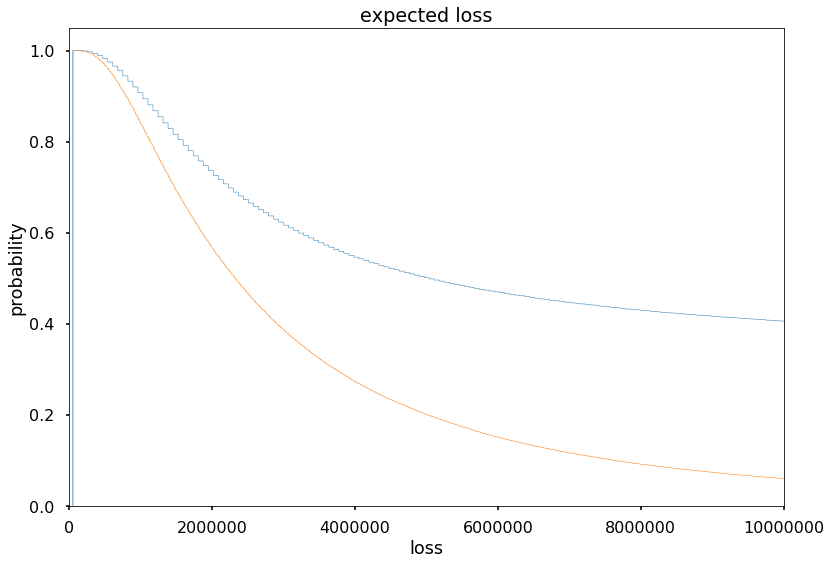

In [40]:
for control in controls:
    controls[control]['implemented'] = False

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
print(risks.expected_loss_deterministic_mean())
print(controls.costs())
risks.plot(ax1)
ax1.set_xlim(left=0, right=10000000)
plt.ticklabel_format(style='plain')

risks.set_optimum_controls(controls)
print(risks.expected_loss_deterministic_mean())
print(controls.costs())
risks.plot(ax1)

plt.ticklabel_format(style='plain')
plt.show()

### 7. Optimize our controls

In [41]:
print(risks.set_optimum_controls(controls).to_latex().replace('\\toprule', '').replace('midrule', 'hline').replace('\\bottomrule', ''))
print(controls.costs(), risks.expected_loss_deterministic_mean())
risks.set_optimum_controls(controls)

\begin{tabular}{lrlr}

{} &    cost &  implemented &  reduction \\
name                                                &         &              &            \\
\hline
Vulnerability management program                    &  100000 &  False & 0.01 \\
Anti-malware software                               &  10000 &  False & 0.10 \\
Two-factor authentication                           &  50000 &  True & 0.10 \\
Disable WiFi                                        &  1000 &  True & 0.00 \\
Physical security at teleoperation facilities       &  10000 &  False & 0.10 \\
Physical security of vehicles                       &  100000 &  True & 0.10 \\
Redundant teleoperation facility                    &  100000 &  False & 0.01 \\
Autonomous system protections for remote operations &  500000 &  True & 0.01 \\
Background checks for drivers                       &  10000 &  True & 0.01 \\

\end{tabular}

661000 3743660.4082991034


,cost,implemented,reduction
name,,,
Vulnerability management program,100000,False,0.01
Anti-malware software,10000,False,0.10
Two-factor authentication,50000,True,0.10
Disable WiFi,1000,True,0.00
Physical security at teleoperation facilities,10000,False,0.10
Physical security of vehicles,100000,True,0.10
Redundant teleoperation facility,100000,False,0.01
Autonomous system protections for remote operations,500000,True,0.01
Background checks for drivers,10000,True,0.01


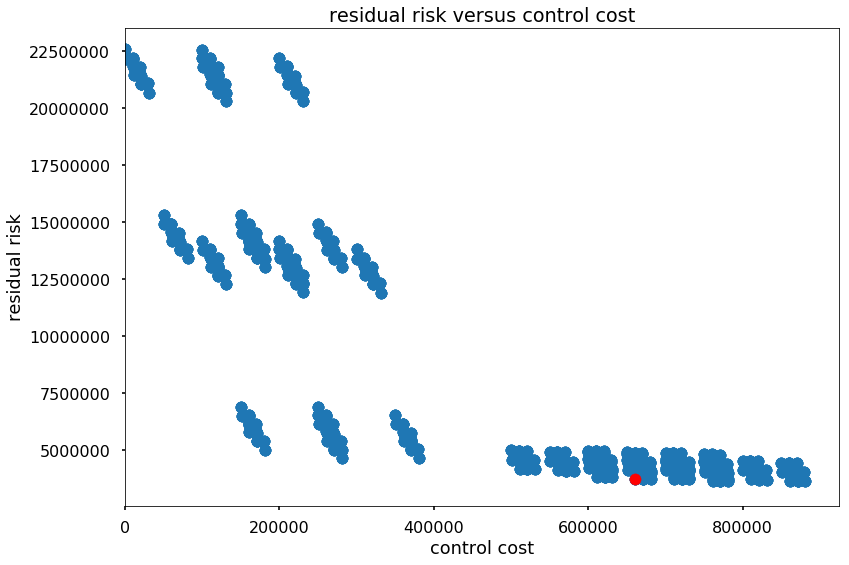

{'Vulnerability management program': {'name': 'Vulnerability management program', 'cost': 100000, 'reduction': 0.01, 'implemented': False}, 'Anti-malware software': {'name': 'Anti-malware software', 'cost': 10000, 'reduction': 0.1, 'implemented': False}, 'Two-factor authentication': {'name': 'Two-factor authentication', 'cost': 50000, 'reduction': 0.1, 'implemented': True}, 'Disable WiFi': {'name': 'Disable WiFi', 'cost': 1000, 'reduction': 0, 'implemented': True}, 'Physical security at teleoperation facilities': {'name': 'Physical security at teleoperation facilities', 'cost': 10000, 'reduction': 0.1, 'implemented': False}, 'Physical security of vehicles': {'name': 'Physical security of vehicles', 'cost': 100000, 'reduction': 0.1, 'implemented': True}, 'Redundant teleoperation facility': {'name': 'Redundant teleoperation facility', 'cost': 100000, 'reduction': 0.01, 'implemented': False}, 'Autonomous system protections for remote operations': {'name': 'Autonomous system protections fo

In [42]:
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
risks.plot_risk_cost_matrix(controls, axes)
plt.ticklabel_format(style='plain')
plt.show()
controls

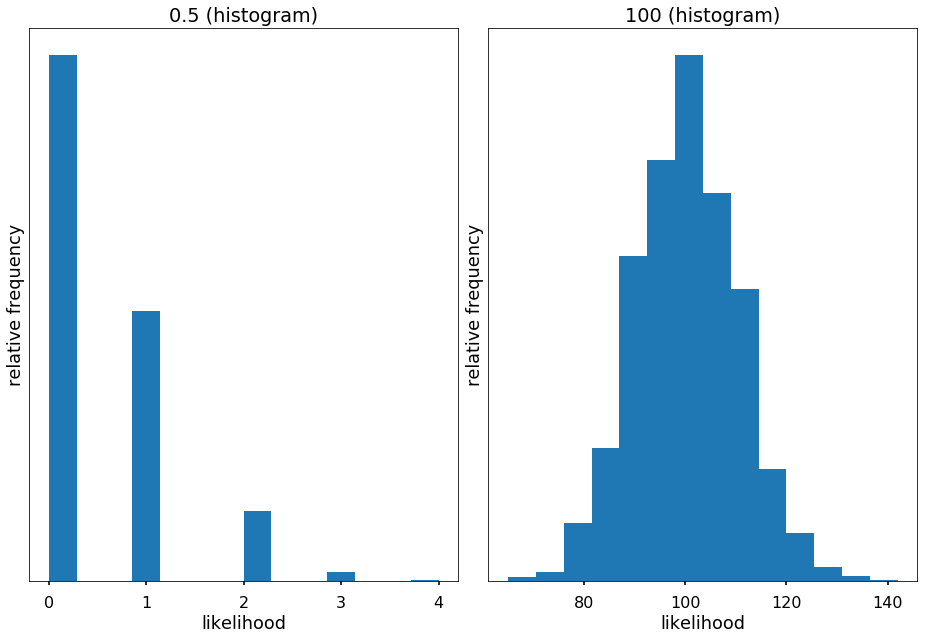

In [43]:
fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
Likelihood(.5).plot(axes=ax1)
ax1.get_yaxis().set_ticks([])

ax3 = fig.add_subplot(1, 2, 2)
Likelihood(100).plot(axes=ax3)
ax3.get_yaxis().set_ticks([])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [44]:
results = risks.sensitivity_test(controls)

In [45]:
list(map(list, results)).count([{'name': 'Vulnerability management program', 'cost': 100000, 'reduction': 0.01, 'implemented': False},
  {'name': 'Anti-malware software', 'cost': 10000, 'reduction': 0.1, 'implemented': False},
  {'name': 'Two-factor authentication', 'cost': 50000, 'reduction': 0.1, 'implemented': True},
  {'name': 'Disable WiFi', 'cost': 1000, 'reduction': 0, 'implemented': True},
  {'name': 'Physical security at teleoperation facilities', 'cost': 10000, 'reduction': 0.1, 'implemented': False},
  {'name': 'Physical security of vehicles', 'cost': 100000, 'reduction': 0.1, 'implemented': True},
  {'name': 'Redundant teleoperation facility', 'cost': 100000, 'reduction': 0.01, 'implemented': False},
  {'name': 'Autonomous system protections for remote operations', 'cost': 500000, 'reduction': 0.01, 'implemented': True},
  {'name': 'Background checks for drivers', 'cost': 10000, 'reduction': 0.01, 'implemented': True}])

1000

In [46]:
import json

cvefile = {}  # https://nvd.nist.gov/vuln/data-feeds
for year in range(2002, 2019):
    with open('/Users/david/Desktop/py/nvdcve-1.0-' + str(year) + '.json') as f:
        cvefile[year] = json.load(f)

In [47]:
count = 0
for year in range(2008, 2018):  # max is 2002, 2019 (2002 to 2018)
    for cve in cvefile[year]['CVE_Items']:
        for vendor in cve['cve']['affects']['vendor']['vendor_data']:
            for product in vendor['product']['product_data']:
                if product['product_name'] == 'ios':  # 11 HIGH in 10 years...
                    count += 1
                    try:
                        pass
                        # print(year, cve['impact']['baseMetricV2']['severity'], cve['cve']['description'])
                    except KeyError as e:
                        pass
print(count)

365


In [48]:
import pandas
df = pandas.read_csv('/Users/david/Desktop/py/nist_800_30_risk_table.csv', header=0, index_col=0)
df.to_latex()

'\\begin{tabular}{llllll}\n\\toprule\n{} &  Very Low &       Low &  Moderate &      High &  Very High \\\\\n\\midrule\nVery High &  Very Low &  Low &  Moderate &  High &  Very High \\\\\nHigh      &  Very Low &  Low &  Moderate &  High &  Very High \\\\\nModerate  &  Very Low &  Low &  Moderate &  Moderate &  High \\\\\nLow       &  Very Low &  Low &  Low &  Low &  Moderate \\\\\nVery Low  &  Very Low &  Very Low &  Very Low &  Low &  Moderate \\\\\n\\bottomrule\n\\end{tabular}\n'

In [49]:
    def to_dendrogram(self, filename: str = None) -> None:
        if not filename:
            filename = self.name + '.html'
        with open(filename, 'w') as f:
            f.write(dendrogram(self.to_dict_list()))



In [50]:
threat_sources = ThreatSources()
threat_events = ThreatEvents()
vulnerabilities = Vulnerabilities()
controls = Controls()
risks = Risks()

system = Tree(name='Autonomous Vehicle System')
threat_sources.new('Sample Threat Source')
sample_impact_cost = 10000
sample_impact = Impact('Sample Impact', np.log(sample_impact_cost), 1)
sample_control_cost = 1000
sample_control_reduction = .1
controls.new('Sample Control', 1000, sample_control_reduction)
risks.new(
    vulnerabilities.new(
        threat_events.new("Sample Threat Event", threat_sources['Sample Threat Source']),
        system,
        [controls['Sample Control']]),
    Likelihood(.1),
    sample_impact)

{'name': "Sample Threat Event -> /Autonomous Vehicle System | [{'name': 'Sample Control', 'cost': 1000, 'reduction': 0.1, 'implemented': True}] -> 0.1 -> Sample Impact", 'vulnerability': {'name': "Sample Threat Event -> /Autonomous Vehicle System | [{'name': 'Sample Control', 'cost': 1000, 'reduction': 0.1, 'implemented': True}]", 'threat_event': {'name': 'Sample Threat Event', 'threat_source': {'name': 'Sample Threat Source'}}, 'system': {}, 'controls': [{'name': 'Sample Control', 'cost': 1000, 'reduction': 0.1, 'implemented': True}]}, 'likelihood': {'name': '0.1', 'lam': 0.1}, 'impact': {'name': 'Sample Impact', 'mean': 16487.212707001298, 'median': 10000.00000000001, 'mu': 9.210340371976184, 'sigma': 1}}